In [25]:
from IPython.display import HTML

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output
import optuna
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [26]:
dfTrain = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col = 'id')
dfTest = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col = 'id')
dfSubmission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
target = 'Premium Amount'

In [27]:
print('--- Train ---\n')
print(100*dfTrain.isnull().sum() / dfTrain.shape[0])
print('\n')
print('--- Test ---\n')
print(100*dfTest.isnull().sum() / dfTest.shape[0])

print(dfTrain.shape)
print(dfTest.shape)

--- Train ---

Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64


--- Test ---

Age                      1.561125
Gender                   0.000000
Annual Income            3.732500
Marital Status           1.542000
Number of Dependents     9.141250
Education Level          0.000000
Occupation              29.890625
Health Score             6.181125
Lo

In [28]:
def preprocess(df):
    if 'Policy Start Date' in df.columns: df['Policy Start Date'] = pd.to_datetime(df.pop('Policy Start Date')).dt.year
    numColumns = [col for col in df.select_dtypes(include=["number"]).columns if col != "Premium Amount"]
    catColumns = df.select_dtypes(include=["object"]).columns
    columns_to_fill = ["Education Level", "Customer Feedback", "Exercise Frequency"]
    
    for c in catColumns: df[c].fillna("missing", inplace=True)

    # Ordinal Mapping
    ordinal_mappings = {
        "Education Level": ["missing", "High School", "Bachelor's", "Master's", "PhD"],
        "Customer Feedback": ["missing", "Poor", "Average", "Good"],
        "Exercise Frequency": ["missing", "Rarely", "Monthly", "Weekly", "Daily"]}

    encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_mappings])
    columns_to_encode = list(ordinal_mappings.keys())
    df[columns_to_encode] = encoder.fit_transform(df[columns_to_encode])
    
    df["Annual Income"] = np.log1p(df["Annual Income"])

    # One-hot encoding
    non_ordinal_columns = [c for c in catColumns if c not in ordinal_mappings]
    for c in non_ordinal_columns: 
        if c in df.columns: df = pd.get_dummies(df, columns=[c], drop_first=True)  
    
    return df

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [29]:
dfTrain = preprocess(dfTrain)
dfTest = preprocess(dfTest)

dfTrain = dfTrain.drop(columns=['Education Level', 'Gender_Male', 'Policy Type_Comprehensive', 'Smoking Status_Yes', 'Occupation_Self-Employed', 'Occupation_Unemployed', 'Location_Urban', 'Policy Type_Premium'])
dfTest = dfTest.drop(columns=['Education Level', 'Gender_Male', 'Policy Type_Comprehensive', 'Smoking Status_Yes', 'Occupation_Self-Employed', 'Occupation_Unemployed', 'Location_Urban', 'Policy Type_Premium'])


In [30]:
print('--- Train ---\n')
print(100*dfTrain.isnull().sum() / dfTrain.shape[0])
print('\n')
print('--- Test ---\n')
print(100*dfTest.isnull().sum() / dfTest.shape[0])

print(dfTrain.shape)
print(dfTest.shape)

--- Train ---

Age                        1.558750
Annual Income              3.745750
Number of Dependents       9.139333
Health Score               6.173000
Previous Claims           30.335750
Vehicle Age                0.000500
Credit Score              11.490167
Customer Feedback          0.000000
Premium Amount             0.000000
Policy Start Date          0.000000
Marital Status_missing     0.000000
Occupation_missing         0.000000
Property Type_Condo        0.000000
dtype: float64


--- Test ---

Age                        1.561125
Annual Income              3.732500
Number of Dependents       9.141250
Health Score               6.181125
Previous Claims           30.350250
Vehicle Age                0.000375
Credit Score              11.431375
Customer Feedback          0.000000
Policy Start Date          0.000000
Marital Status_missing     0.000000
Occupation_missing         0.000000
Property Type_Condo        0.000000
dtype: float64
(1200000, 13)
(800000, 12)


In [31]:
# Define the target column and separate features and target
X = dfTrain.drop(columns=[target])
y = np.log1p(dfTrain[target])

In [32]:
def kfold_cv_ensemble(X, y, xgb_params, n_splits, X_test):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_rmsle = 0
    test_predictions = np.zeros(len(X_test))  # Placeholder for test predictions
    feature_importances = np.zeros(X.shape[1])

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}...")
        
        # Split data into training and validation sets for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize and train the XGBoost model
        model_xgb = xgb.XGBRegressor(**xgb_params)
        model_xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Make predictions on validation set
        y_pred_xgb = model_xgb.predict(X_val)
        fold_rmsle_score = rmsle(y_val, y_pred_xgb)
        fold_rmsle += fold_rmsle_score
        print(f"Fold {fold + 1} RMSLE: {fold_rmsle_score:.5f}")
        
        # Accumulate feature importances
        feature_importances += model_xgb.feature_importances_ / n_splits
        
        # Predict on test data
        test_predictions += model_xgb.predict(X_test) / n_splits
        
    # Compute average RMSLE across all folds
    avg_rmsle = fold_rmsle / n_splits
    print(f"Average RMSLE across {n_splits} folds: {avg_rmsle:.5f}")

    # Plot feature importances
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("Feature Importances:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance from XGBoost (Averaged Across Folds)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return test_predictions


Training fold 1...
Fold 1 RMSLE: 0.15826
Training fold 2...
Fold 2 RMSLE: 0.15834
Training fold 3...
Fold 3 RMSLE: 0.15851
Training fold 4...
Fold 4 RMSLE: 0.15768
Training fold 5...
Fold 5 RMSLE: 0.15843
Training fold 6...
Fold 6 RMSLE: 0.15782
Training fold 7...
Fold 7 RMSLE: 0.15778
Training fold 8...
Fold 8 RMSLE: 0.15796
Training fold 9...
Fold 9 RMSLE: 0.15740
Training fold 10...
Fold 10 RMSLE: 0.15898
Average RMSLE across 10 folds: 0.15812
Feature Importances:
                   Feature  Importance
9   Marital Status_missing    0.167029
4          Previous Claims    0.159033
7        Customer Feedback    0.137082
1            Annual Income    0.130385
6             Credit Score    0.109039
3             Health Score    0.085882
8        Policy Start Date    0.078253
10      Occupation_missing    0.029599
0                      Age    0.027112
5              Vehicle Age    0.026118
2     Number of Dependents    0.025648
11     Property Type_Condo    0.024821


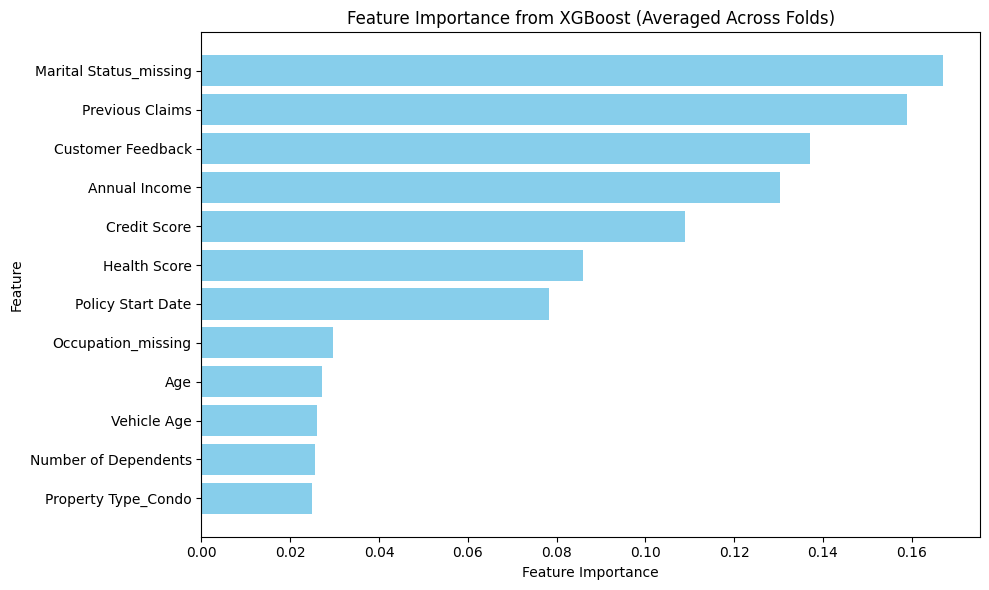

done


In [33]:
xgb_params = {
    'learning_rate': 0.01,
    'n_estimators': 800,
    'max_depth': 9,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'tree_method': 'gpu_hist',
    'missing': np.nan 
}
test_predictions = kfold_cv_ensemble(X, y, xgb_params, 10, dfTest)

# Reverse log transformation for test predictions
y_test_pred = np.expm1(test_predictions)

# Save predictions to a submission file
dfSubmission[target] = y_test_pred
dfSubmission.to_csv('submission.csv', index=False)

print("done")

In [ ]:
def objective_LGB(trial):
    max_depth = trial.suggest_int('max_depth', 6, 12)

    params = { 
        'force_row_wise': True,
        'max_depth': max_depth,
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.05),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'num_leaves': 2**max_depth - 1,
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsle = []

    # Loop through each fold
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Initialize the model with the current hyperparameters
        model = lgb.LGBMRegressor(**params, early_stopping_rounds=50)
        
        # Train the model
        model.fit(
            X_train_fold, y_train_fold, 
            eval_set=[(X_val_fold, y_val_fold)], 
            eval_metric='rmse'
        )
        
        # Make predictions and compute RMSLE
        preds = model.predict(X_val_fold)
        fold_rmsle_score = rmsle(y_val_fold, preds)
        fold_rmsle.append(fold_rmsle_score)
    
    # Return the average RMSLE across all folds
    avg_rmsle = np.mean(fold_rmsle)
    print(f"Average RMSLE across folds: {avg_rmsle:.5f}")
    return avg_rmsle

# Initialize the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective_LGB, n_trials=50)
best_params = study.best_params
print("Best hyperparameters:", best_params)

In [24]:
dfSubmission.head(10)

,id,Premium Amount
0,1200000,790.640829
1,1200001,800.931141
2,1200002,783.997543
3,1200003,796.875901
4,1200004,737.779883
5,1200005,823.123372
6,1200006,1009.229978
7,1200007,696.458513
8,1200008,203.326449
9,1200009,826.643899
